# Weapon Stats

## Setting Up

In [1]:
import pandas as pd
from weapon import max_shots, burst

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")
damage_modifiers = pd.read_csv("datasets/damage_modifiers.csv")

## Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks = weapon_attacks.sort_values(by=["weapon", "fire_mode"])
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32


## Chance to Hit

Soldiers start with an Accuracy value between 40 and 70, giving an average of 55.

To get the change of hit this should by applied to the weapon accuracy. Just multiply them as proportions. So an average of 55 to a weapon of Accuracy 90 means 0.55 * 0.9 = 0.495 chance of hit.

In [3]:
weapon_attacks["chance_to_hit"] = weapon_attacks.apply(lambda x: x["accuracy"] / 100 * 0.55, axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760


## Derived Damage

In [4]:
# weapon_attacks = weapon_attacks.apply(burst, axis=1)
weapon_attacks["burst"] = weapon_attacks.apply(burst, axis=1)
weapon_attacks["expected_damage"] = weapon_attacks.apply(lambda x: x["damage"] * x["chance_to_hit"], axis=1)
weapon_attacks["clip_damage"] = weapon_attacks.apply(lambda x: x["capacity"] * x["damage"], axis=1)
weapon_attacks["turn_max_shots"] = weapon_attacks.apply(max_shots, axis=1)
weapon_attacks["turns_to_reload"] = weapon_attacks.apply(lambda x: x["capacity"] / x["turn_max_shots"], axis=1)
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,chance_to_hit,burst,expected_damage,clip_damage,turn_max_shots,turns_to_reload
47,alien_grenade,1,alien_grenade,90,high_explosive,1.0,grenade,75,65,0.3575,1,32.175,90.0,1,1.000000
13,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,aimed,80,82,0.4510,1,18.942,588.0,1,14.000000
16,auto_cannon,2,auto_cannon_he,44,high_explosive,14.0,aimed,80,82,0.4510,1,19.844,616.0,1,14.000000
19,auto_cannon,2,auto_cannon_inc,48,incendiary,14.0,aimed,80,82,0.4510,1,21.648,672.0,1,14.000000
11,auto_cannon,2,auto_cannon_ap,42,armor_piercing,14.0,auto,40,32,0.1760,3,7.392,588.0,6,2.333333


## Weapon Stats

### Average Damage

Ignoring the rate of fire, but choosing the highest values among the fire modes.

In [5]:
average_damage_mean = weapon_attacks[["weapon", "expected_damage"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [6]:
average_damage_max = weapon_attacks[["weapon", "damage"]]
average_damage_max = average_damage_max.groupby("weapon").mean()

In [7]:
average_damage = average_damage_max.merge(average_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["expected_damage"])
average_damage = average_damage.rename(columns={"damage": "max", "expected_damage": "average"})
average_damage

,max,average
weapon,,
pistol,26.000000,9.867000
rifle,30.000000,11.275000
laser_pistol,46.000000,11.469333
auto_cannon,44.666667,13.921111
grenade,50.000000,17.875000
plasma_pistol,52.000000,19.066667
heavy_cannon,56.000000,23.100000
laser_rifle,60.000000,23.210000
cannon_turret,60.000000,24.750000


Text(0, 0.5, 'Damage')

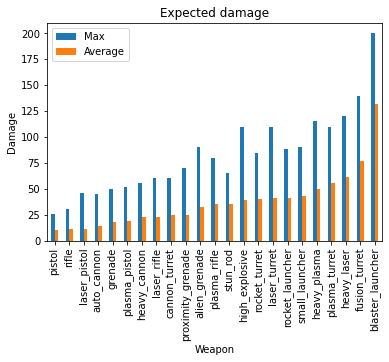

In [8]:
ax = average_damage.plot.bar(title="Expected damage", legend=False)
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Ammo

In [9]:
weapon_ammo = weapon_attacks[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])

# Remove weapons with unlimited ammo
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]

weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


Text(0, 0.5, 'Shots')

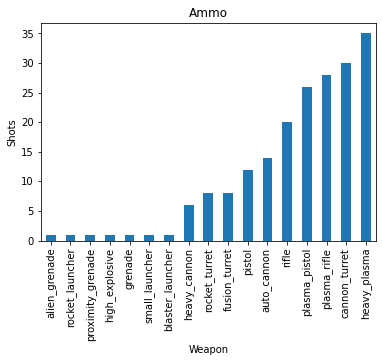

In [10]:
ax = weapon_ammo.plot.bar(title="Ammo", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Shots")

### Damage Per Clip

In [11]:
damage_per_clip = weapon_attacks[["weapon", "clip_damage"]]
damage_per_clip = damage_per_clip.groupby("weapon").max()
damage_per_clip = damage_per_clip.sort_values(by=["clip_damage"])
damage_per_clip = damage_per_clip.dropna()

# Remove weapons with unlimited ammo
damage_per_clip = damage_per_clip[damage_per_clip["clip_damage"] < 10000]

damage_per_clip

,clip_damage
weapon,
grenade,50.0
proximity_grenade,70.0
alien_grenade,90.0
small_launcher,90.0
rocket_launcher,100.0
high_explosive,110.0
blaster_launcher,200.0
pistol,312.0
heavy_cannon,360.0


Text(0, 0.5, 'Damage')

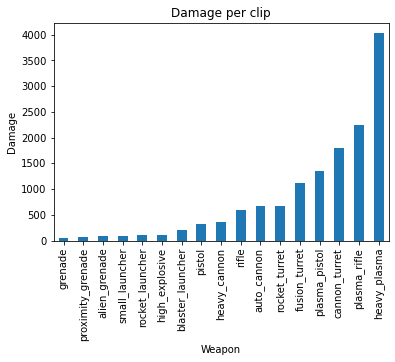

In [12]:
ax = damage_per_clip.plot.bar(title="Damage per clip", legend=False)
ax.set_xlabel("Weapon")
ax.set_ylabel("Damage")

### Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [13]:
shots_per_turn_max = weapon_attacks[["weapon", "turn_max_shots"]]
shots_per_turn_max = shots_per_turn_max.groupby("weapon").max()

In [14]:
shots_per_turn_average = weapon_attacks[["weapon", "turn_max_shots"]]
shots_per_turn_average = shots_per_turn_average.groupby("weapon").mean()

In [15]:
shots_per_turn = shots_per_turn_max.merge(shots_per_turn_average, on="weapon")
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots_x": "turn_shots_max", "turn_max_shots_y": "turn_shots_avg"})
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots_avg"])
shots_per_turn

,turn_shots_max,turn_shots_avg
weapon,,
alien_grenade,1,1.000000
blaster_launcher,1,1.000000
fusion_turret,1,1.000000
grenade,1,1.000000
rocket_launcher,1,1.000000
high_explosive,1,1.000000
proximity_grenade,1,1.000000
rocket_turret,2,1.500000
small_launcher,2,1.500000


Text(0, 0.5, 'Shots')

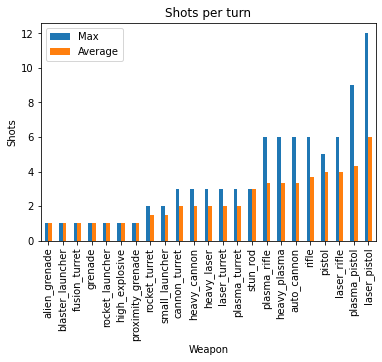

In [16]:
ax = shots_per_turn.plot.bar(title="Shots per turn")
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Shots")

### Turns of Sustained Fire

In [17]:
turns_sustained_fire_max = weapon_attacks[["weapon", "turns_to_reload"]]
turns_sustained_fire_max = turns_sustained_fire_max.groupby("weapon").max()

# Remove weapons with unlimited ammo
turns_sustained_fire_max = turns_sustained_fire_max[turns_sustained_fire_max["turns_to_reload"] < 70]

In [18]:
turns_sustained_fire_average = weapon_attacks[["weapon", "turns_to_reload"]]
turns_sustained_fire_average = turns_sustained_fire_average.groupby("weapon").mean()

# Remove weapons with unlimited ammo
turns_sustained_fire_average = turns_sustained_fire_average[turns_sustained_fire_average["turns_to_reload"] < 70]

In [19]:
turns_sustained_fire = turns_sustained_fire_max.merge(turns_sustained_fire_average, on="weapon")
turns_sustained_fire = turns_sustained_fire.rename(columns={"turns_to_reload_x": "turns_sustained_fire_max", "turns_to_reload_y": "turns_sustained_fire_avg"})
turns_sustained_fire = turns_sustained_fire.sort_values(by=["turns_sustained_fire_max"])
turns_sustained_fire

,turns_sustained_fire_max,turns_sustained_fire_avg
weapon,,
alien_grenade,1.0,1.000000
rocket_launcher,1.0,1.000000
proximity_grenade,1.0,1.000000
grenade,1.0,1.000000
high_explosive,1.0,1.000000
blaster_launcher,1.0,1.000000
small_launcher,1.0,0.750000
pistol,4.0,3.200000
heavy_cannon,6.0,4.000000


Text(0, 0.5, 'Turns')

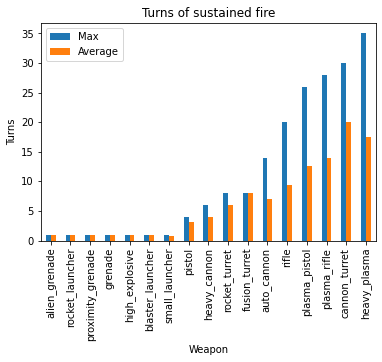

In [20]:
ax = turns_sustained_fire.plot.bar(title="Turns of sustained fire")
ax.legend(["Max", "Average"])
ax.set_xlabel("Weapon")
ax.set_ylabel("Turns")